# Неделя 3. Соревнование.
В этом задании вам нужно воспользоваться опытом предыдущих недель, чтобы побить бейзлайн в [соревновании по сентимент-анализу отзывов](https://www.kaggle.com/c/product-reviews-sentiment-analysis-light) на товары на Kaggle Inclass.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve
from nltk.corpus import stopwords
from random import shuffle
import random

In [2]:
# seed = random.randint(0, 10000)
seed = 8269
seed

8269

In [3]:
train_data = pd.read_csv(
    "..\..\Data\products_sentiment_train.tsv",
    "\t",
    names=["text", "class"],
    dtype={ "text": "str", "class": "int" })
train_data.head()

,text,class
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [4]:
test_data = pd.read_csv(
    "..\..\Data\products_sentiment_test.tsv",
    "\t",
    index_col="Id",
    dtype={ "text": "str", "Id": "int" })
test_data.head()

,text
Id,
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


In [5]:
texts = train_data["text"].tolist()
classes = train_data["class"].tolist()

In [12]:
def score_model_template(
    model_name,
    model_pipe,
    frame,
    frame_columns,
    score_texts,
    score_classes,
    print_results=True
):
    accuracy_scores = cross_val_score(
        model_pipe,
        score_texts,
        score_classes,
        scoring="accuracy")
    roc_auc_scores = cross_val_score(
        model_pipe,
        score_texts,
        score_classes,
        scoring="roc_auc")
    average_accuracy = np.average(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)
    average_roc_auc = np.average(roc_auc_scores)
    std_roc_auc = np.std(roc_auc_scores)
    frame = frame.append(pd.DataFrame([
        [average_accuracy, std_accuracy, average_roc_auc, std_roc_auc]
    ], index=[model_name], columns=frame_columns))
    if(print_results):
        print ("Accuracy:\n\tAverage: {0:.3f}\n\tStandard Deviation: {1:.3f}".format(
            average_accuracy,
            std_accuracy))
        print ("ROC AUC:\n\tAverage: {0:.3f}\n\tStandard Deviation: {1:.3f}".format(
            np.average(roc_auc_scores),
            np.std(roc_auc_scores)))
    return frame

# Построить ROC AUC кривую
def ROC_AUC_curve(vectorizer_factory, model_factory):
    rate = 0.3
    vectorizer = vectorizer_factory()
    vectorized_texts = vectorizer.fit_transform(texts)
    train_texts, test_texts, train_classes, test_classes = train_test_split(
        vectorized_texts,
        classes,
        test_size=rate,
        random_state=seed,
        stratify=classes
    )
    model = model_factory().fit(train_texts, train_classes)
    probabilities = list(map(lambda pred: pred[1], model.predict_proba(test_texts)))

    fpr, tpr, thr = roc_curve(test_classes, probabilities)
    distance,fpr_v,tpr_v,thr_v = min(zip(np.sqrt((1.-tpr)**2+fpr**2),fpr,tpr,thr), key=lambda d:d[0])

    plt.plot(fpr, tpr, label="ROC AUC curve")
    plt.scatter(fpr_v, tpr_v, color="red")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("ROC AUC")
    return distance

def model_metrics(vectorizer_factory, model_factory):
    vectorizer = vectorizer_factory()
    vectorized_texts = vectorizer.fit_transform(texts)
    full_model = model_factory().fit(vectorized_texts, classes)
    
    distance = ROC_AUC_curve(vectorizer_factory, model_factory)
    
    main_features = list(map(
        lambda feature: feature[0],
        sorted(
            zip(vectorizer.get_feature_names(), np.abs(full_model.coef_[0])),
            key=lambda feature: feature[1],
            reverse=True)[:5]))
    print ("Main features:", main_features)
    return distance

In [18]:
result_columns = ["Accuracy", "Accuracy_std", "ROC_AUC", "ROC_AUC_std"]
# results = pd.DataFrame(columns=result_columns)
results = pd.read_csv(
    "..\..\Results\sentiment_kaggle_results_table.csv",
    ",",
    index_col="Id")
results

,Accuracy,Accuracy_std,ROC_AUC,ROC_AUC_std
Id,,,,
"Tfidf N-grams (1,6) logistic",0.837519,0.000181,0.923966,0.008160
Regularized TF-IDF logistic. C=0.8,0.836734,0.000664,0.922593,0.008359
"Count N-grams (1,5) logistic",0.836348,0.009070,0.922453,0.006407
Count Logistic,0.817895,0.010648,0.897232,0.009240
Count NLTK English stopwords logistic,0.812407,0.008775,0.891127,0.005639
TF-IDF Logistic baseline,0.805341,0.008842,0.894245,0.005339
Count Sklearn English stopwords logistic,0.804168,0.009856,0.887977,0.005197
Tfidf NLTK English stopwords logistic,0.801015,0.008513,0.884795,0.005838
Tfidf Sklearn English stopwords logistic,0.791995,0.002666,0.878878,0.004080


# Data balancing (Oversampling)

In [19]:
def balance_data(input_texts, input_classes, diff_size = 548):
    negative_texts, negative_classes = zip(*filter(lambda row: row[1] == 0, zip(input_texts, input_classes)))
    negative_texts_list = []
    random.seed(seed)
    for i in range(0, diff_size):
        negative_texts_list = negative_texts_list + [negative_texts[random.randint(0, len(negative_texts)- 1)]]
        
    balanced_texts = input_texts + negative_texts_list
    balanced_classes = input_classes + ([0] * diff_size)
    balanced_data = list(zip(balanced_texts, balanced_classes))
    shuffle(balanced_data)
    return zip(*balanced_data)

def score_model_oversampling(
    model_name,
    model_pipe,
    result_frame,
    result_frame_columns,
    print_results=True
):
    balanced_texts, balanced_classes = balance_data(texts, classes)
    return score_model_template(
        model_name,
        model_pipe,
        result_frame,
        result_frame_columns,
        balanced_texts,
        balanced_classes,
        print_results
    )

# Random Forest

## Count Vectorizer

In [21]:
count_pipe = Pipeline([
    ("vectorize", CountVectorizer()),
    ("model", RandomForestClassifier(random_state=seed))])
results = score_model_oversampling(
    "Count Random Forest",
    count_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.799
	Standard Deviation: 0.003
ROC AUC:
	Average: 0.885
	Standard Deviation: 0.006


### English stopwords

In [22]:
english_stopwords = stopwords.words("english")
nltk_stopwords_count = Pipeline([
    ("vectorize", CountVectorizer(stop_words=english_stopwords)),
    ("model", RandomForestClassifier(random_state=seed))
])
results = score_model_oversampling(
    "Count NLTK English stopwords random forest",
    nltk_stopwords_count,
    results,
    result_columns
)

Accuracy:
	Average: 0.779
	Standard Deviation: 0.012
ROC AUC:
	Average: 0.872
	Standard Deviation: 0.020


In [23]:
sklearn_stopwords_count = Pipeline([
    ("vectorize", CountVectorizer(stop_words="english")),
    ("model", RandomForestClassifier(random_state=seed))
])
results = score_model_oversampling(
    "Count Sklearn English stopwords random forest",
    sklearn_stopwords_count,
    results,
    result_columns
)

Accuracy:
	Average: 0.786
	Standard Deviation: 0.009
ROC AUC:
	Average: 0.875
	Standard Deviation: 0.006


### N-grams

In [24]:
results_ngram = results
for max_ngram in range(2, 30):
    sklearn_count_ngram = Pipeline([
        ("vectorize", CountVectorizer(analyzer="word", ngram_range=(1, max_ngram))),
        ("model", RandomForestClassifier(random_state=seed))
    ])
    results_ngram = score_model_oversampling(
        "Count N-grams (1,{0}) random forest".format(max_ngram),
        sklearn_count_ngram,
        results_ngram,
        result_columns,
        False
    )
results_ngram

,Accuracy,Accuracy_std,ROC_AUC,ROC_AUC_std
"Tfidf N-grams (1,6) logistic",0.837519,0.000181,0.923966,0.008160
Regularized TF-IDF logistic. C=0.8,0.836734,0.000664,0.922593,0.008359
"Count N-grams (1,5) logistic",0.836348,0.009070,0.922453,0.006407
Count Logistic,0.817895,0.010648,0.897232,0.009240
Count NLTK English stopwords logistic,0.812407,0.008775,0.891127,0.005639
TF-IDF Logistic baseline,0.805341,0.008842,0.894245,0.005339
Count Sklearn English stopwords logistic,0.804168,0.009856,0.887977,0.005197
Tfidf NLTK English stopwords logistic,0.801015,0.008513,0.884795,0.005838
Tfidf Sklearn English stopwords logistic,0.791995,0.002666,0.878878,0.004080
Hashing NLTK English stopwords logistic,0.782572,0.008452,0.870553,0.006265


In [25]:
sklearn_count_ngram_1_8 = Pipeline([
    ("vectorize", CountVectorizer(analyzer="word", ngram_range=(1, 8))),
    ("model", RandomForestClassifier(random_state=seed))
])
results = score_model_oversampling(
    "Count N-grams (1,8) random forest",
    sklearn_count_ngram_1_8,
    results,
    result_columns
)

Accuracy:
	Average: 0.818
	Standard Deviation: 0.004
ROC AUC:
	Average: 0.884
	Standard Deviation: 0.004


## TF-IDF Vectorizer

In [26]:
tfidf_pipe = Pipeline([
    ("vectorize", TfidfVectorizer()),
    ("model", RandomForestClassifier(random_state=seed))])
results = score_model_oversampling(
    "TF-IDF random forest baseline",
    tfidf_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.782
	Standard Deviation: 0.005
ROC AUC:
	Average: 0.876
	Standard Deviation: 0.005


### English stopwords

In [27]:
english_stopwords = stopwords.words("english")
nltk_stopwords_tfidf = Pipeline([
    ("vectorize", TfidfVectorizer(stop_words=english_stopwords)),
    ("model", RandomForestClassifier(random_state=seed))
])
results = score_model_oversampling(
    "Tfidf NLTK English stopwords random forest",
    nltk_stopwords_tfidf,
    results,
    result_columns
)

Accuracy:
	Average: 0.783
	Standard Deviation: 0.003
ROC AUC:
	Average: 0.874
	Standard Deviation: 0.005


In [28]:
sklearn_stopwords_tfidf = Pipeline([
    ("vectorize", TfidfVectorizer(stop_words="english")),
    ("model", RandomForestClassifier(random_state=seed))
])
results = score_model_oversampling(
    "Tfidf Sklearn English stopwords random forest",
    sklearn_stopwords_tfidf,
    results,
    result_columns
)

Accuracy:
	Average: 0.767
	Standard Deviation: 0.006
ROC AUC:
	Average: 0.869
	Standard Deviation: 0.009


### N-grams

In [29]:
results_ngram = results
for max_ngram in range(2, 30):
    sklearn_tfidf_ngram = Pipeline([
        ("vectorize", TfidfVectorizer(analyzer="word", ngram_range=(1, max_ngram))),
        ("model", RandomForestClassifier(random_state=seed))
    ])
    results_ngram = score_model_oversampling(
        "Tfidf N-grams (1,{0}) random forest".format(max_ngram),
        sklearn_tfidf_ngram,
        results_ngram,
        result_columns,
        False
    )
results_ngram

,Accuracy,Accuracy_std,ROC_AUC,ROC_AUC_std
"Tfidf N-grams (1,6) logistic",0.837519,0.000181,0.923966,0.008160
Regularized TF-IDF logistic. C=0.8,0.836734,0.000664,0.922593,0.008359
"Count N-grams (1,5) logistic",0.836348,0.009070,0.922453,0.006407
Count Logistic,0.817895,0.010648,0.897232,0.009240
Count NLTK English stopwords logistic,0.812407,0.008775,0.891127,0.005639
TF-IDF Logistic baseline,0.805341,0.008842,0.894245,0.005339
Count Sklearn English stopwords logistic,0.804168,0.009856,0.887977,0.005197
Tfidf NLTK English stopwords logistic,0.801015,0.008513,0.884795,0.005838
Tfidf Sklearn English stopwords logistic,0.791995,0.002666,0.878878,0.004080
Hashing NLTK English stopwords logistic,0.782572,0.008452,0.870553,0.006265


In [32]:
results_ngram = results
for min_ngram in range(2, 11):
    sklearn_tfidf_ngram = Pipeline([
        ("vectorize", TfidfVectorizer(analyzer="word", ngram_range=(min_ngram, 11))),
        ("model", RandomForestClassifier(random_state=seed))
    ])
    results_ngram = score_model_oversampling(
        "Tfidf N-grams ({0}, 11) random forest".format(min_ngram),
        sklearn_tfidf_ngram,
        results_ngram,
        result_columns,
        False
    )
results_ngram

,Accuracy,Accuracy_std,ROC_AUC,ROC_AUC_std
"Tfidf N-grams (1,6) logistic",0.837519,0.000181,0.923966,0.008160
Regularized TF-IDF logistic. C=0.8,0.836734,0.000664,0.922593,0.008359
"Count N-grams (1,5) logistic",0.836348,0.009070,0.922453,0.006407
Count Logistic,0.817895,0.010648,0.897232,0.009240
Count NLTK English stopwords logistic,0.812407,0.008775,0.891127,0.005639
TF-IDF Logistic baseline,0.805341,0.008842,0.894245,0.005339
Count Sklearn English stopwords logistic,0.804168,0.009856,0.887977,0.005197
Tfidf NLTK English stopwords logistic,0.801015,0.008513,0.884795,0.005838
Tfidf Sklearn English stopwords logistic,0.791995,0.002666,0.878878,0.004080
Hashing NLTK English stopwords logistic,0.782572,0.008452,0.870553,0.006265


In [33]:
sklearn_tfidf_ngram_1_11 = Pipeline([
    ("vectorize", TfidfVectorizer(analyzer="word", ngram_range=(1, 11))),
    ("model", RandomForestClassifier(random_state=seed))
])
results = score_model_oversampling(
    "Tfidf N-grams (1,11) random forest",
    sklearn_tfidf_ngram_1_11,
    results,
    result_columns
)

Accuracy:
	Average: 0.791
	Standard Deviation: 0.011
ROC AUC:
	Average: 0.872
	Standard Deviation: 0.004


In [ ]:
model_metrics(
    lambda: TfidfVectorizer(analyzer="word", ngram_range=(1, 11)),
    lambda: RandomForestClassifier(random_state=seed))

### Regularization coefficient

In [ ]:
mdl = RandomForestClassifier(random_state=seed, C=coef)

In [37]:
coef_results = results
for coef_part in range(1, 20):
    coef = float(coef_part)/10
    regularized_tfidf = Pipeline([
        ("vectorize", TfidfVectorizer(analyzer="word", ngram_range=(1, 6))),
        ("model", RandomForestClassifier(random_state=seed, C=coef))
    ])
    coef_results = score_model_oversampling(
        "Regularized TF-IDF random forest. C={0}".format(coef),
        regularized_tfidf,
        coef_results,
        result_columns,
        False
    )
coef_results

TypeError: __init__() got an unexpected keyword argument 'C'

In [31]:
regularized_tfidf_c_0_8 = Pipeline([
    ("vectorize", TfidfVectorizer(analyzer="word", ngram_range=(1, 6))),
    ("model", LogisticRegression(random_state=seed, C=0.8))
])
results = score_model_oversampling(
    "Regularized TF-IDF logistic. C=0.8",
    regularized_tfidf_c_0_8,
    results,
    result_columns
)

Accuracy:
	Average: 0.837
	Standard Deviation: 0.001
ROC AUC:
	Average: 0.923
	Standard Deviation: 0.008


Main features: ['great', 'not', 'and', 'only', 'good']


0.30825150859173023

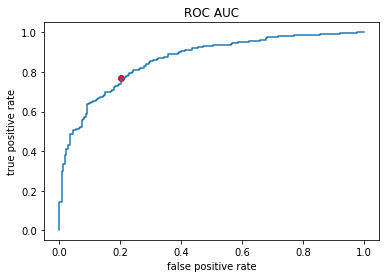

In [20]:
model_metrics(
    lambda: TfidfVectorizer(analyzer="word", ngram_range=(1, 6)),
    lambda: LogisticRegression(random_state=seed, C=1.6))

## Hashing Vectorizer

In [38]:
hashing_pipe = Pipeline([
    ("vectorize", HashingVectorizer()),
    ("model", RandomForestClassifier(random_state=seed))])
results = score_model_oversampling(
    "Hashing random forest baseline",
    hashing_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.781
	Standard Deviation: 0.013
ROC AUC:
	Average: 0.872
	Standard Deviation: 0.009


### English stopwords

In [39]:
english_stopwords = stopwords.words("english")
nltk_stopwords_hashing = Pipeline([
    ("vectorize", HashingVectorizer(stop_words=english_stopwords)),
    ("model", RandomForestClassifier(random_state=seed))
])
results = score_model_oversampling(
    "Hashing NLTK English stopwords random forest",
    nltk_stopwords_hashing,
    results,
    result_columns
)

Accuracy:
	Average: 0.777
	Standard Deviation: 0.016
ROC AUC:
	Average: 0.869
	Standard Deviation: 0.009


In [40]:
sklearn_stopwords_hashing = Pipeline([
    ("vectorize", HashingVectorizer(stop_words="english")),
    ("model", RandomForestClassifier(random_state=seed))
])
results = score_model_oversampling(
    "Hashing Sklearn English stopwords random forest",
    sklearn_stopwords_hashing,
    results,
    result_columns
)

Accuracy:
	Average: 0.782
	Standard Deviation: 0.026
ROC AUC:
	Average: 0.866
	Standard Deviation: 0.019


# Result

In [41]:
results = results.sort_values("Accuracy", ascending=False)
results.to_csv("..\..\Results\sentiment_kaggle_results_table.csv", index=True, index_label="Id")
results

,Accuracy,Accuracy_std,ROC_AUC,ROC_AUC_std
"Tfidf N-grams (1,6) logistic",0.837519,0.000181,0.923966,0.008160
Regularized TF-IDF logistic. C=0.8,0.836734,0.000664,0.922593,0.008359
"Count N-grams (1,5) logistic",0.836348,0.009070,0.922453,0.006407
"Count N-grams (1,8) random forest",0.817899,0.003519,0.883957,0.004047
Count Logistic,0.817895,0.010648,0.897232,0.009240
Count NLTK English stopwords logistic,0.812407,0.008775,0.891127,0.005639
TF-IDF Logistic baseline,0.805341,0.008842,0.894245,0.005339
Count Sklearn English stopwords logistic,0.804168,0.009856,0.887977,0.005197
Tfidf NLTK English stopwords logistic,0.801015,0.008513,0.884795,0.005838
Count Random Forest,0.799059,0.002669,0.884808,0.006048


In [32]:
test_texts = test_data["text"].tolist()
balanced_texts, balanced_classes = balance_data(texts, classes)
model = regularized_tfidf_c_0_8.fit(balanced_texts, balanced_classes)
result_frame = pd.DataFrame(model.predict(test_texts), columns=["y"])
result_frame.to_csv("..\\..\\Results\\balanced_tfidf_ng1_6_c_0_8_logistic.csv", index=True, index_label="Id")
result_frame.head()

,y
0,1
1,0
2,1
3,1
4,0
